In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('spam.csv',encoding='latin1')

In [9]:
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [10]:
df.dropna(axis=1,inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [15]:
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [18]:
df = df.rename(columns={'v1':'label','v2':'message'}) if 'v1' in df.columns else df

In [19]:
df = df[['label','message']]

In [20]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label']) 

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

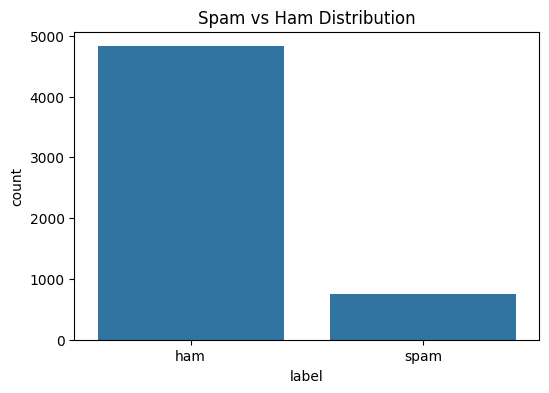

In [28]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Spam vs Ham Distribution')
plt.show()

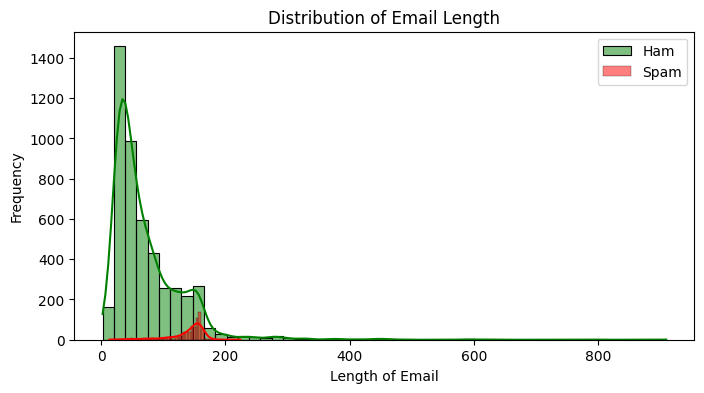

In [29]:
# ----------------------------
df['message_length'] = df['message'].apply(len)
plt.figure(figsize=(8,4))
sns.histplot(df[df['label']=='ham']['message_length'], color='green', label='Ham', kde=True, bins=50)
sns.histplot(df[df['label']=='spam']['message_length'], color='red', label='Spam', kde=True, bins=50)
plt.title('Distribution of Email Length')
plt.xlabel('Length of Email')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [34]:
from wordcloud import WordCloud
spam_text = ' '.join(df[df['label']=='spam']['message'])
ham_text = ' '.join(df[df['label']=='ham']['message'])

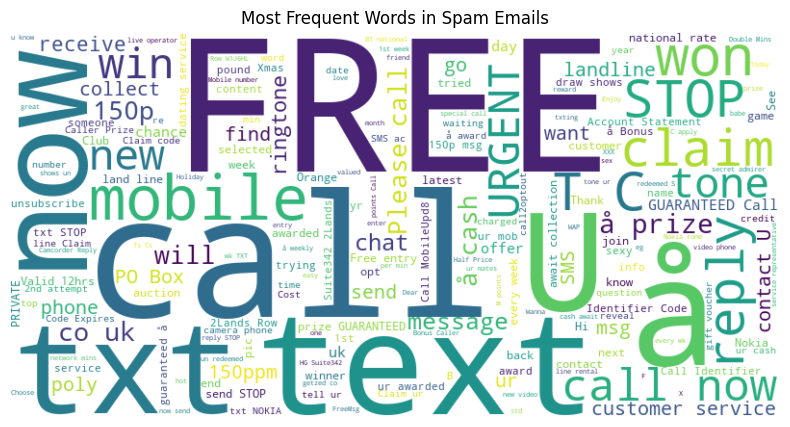

In [35]:
plt.figure(figsize=(10,5))
wordcloud_spam = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Spam Emails')
plt.show()

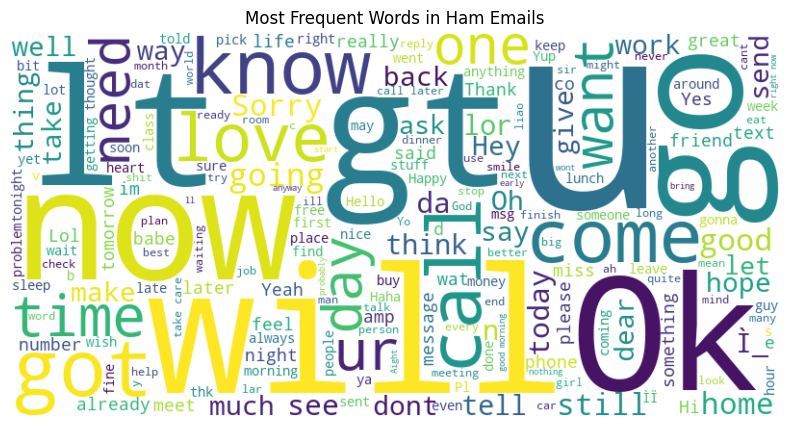

In [36]:
plt.figure(figsize=(10,5))
wordcloud_ham = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Ham Emails')
plt.show()


In [41]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
def top_words(text_series, n=20):
    words = ' '.join(text_series).split()
    return pd.DataFrame(Counter(words).most_common(n), columns=['Word','Count'])


In [42]:
spam_common = top_words(df[df['label']=='spam']['message'])
ham_common = top_words(df[df['label']=='ham']['message'])

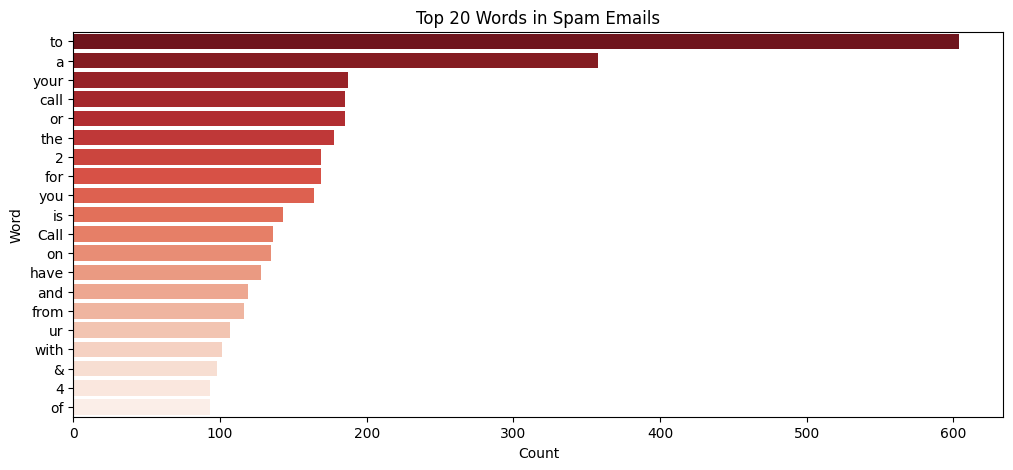

In [43]:
plt.figure(figsize=(12,5))
sns.barplot(x='Count', y='Word', data=spam_common, palette='Reds_r')
plt.title('Top 20 Words in Spam Emails')
plt.show()


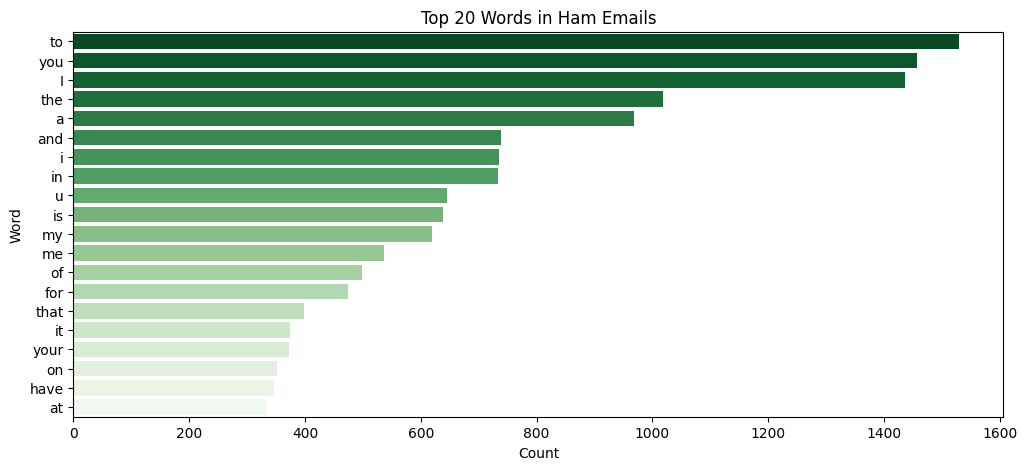

In [44]:
plt.figure(figsize=(12,5))
sns.barplot(x='Count', y='Word', data=ham_common, palette='Greens_r')
plt.title('Top 20 Words in Ham Emails')
plt.show()

,label,message,label_encoded,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,161
5568,ham,Will Ì_ b going to esplanade fr home?,0,37
5569,ham,"Pity, * was in mood for that. So...any other s...",0,57
5570,ham,The guy did some bitching but I acted like i'd...,0,125


In [47]:
from sklearn.model_selection import train_test_split

X_text = df['message']
X_len  = df[['message_length']]   
y = df['label_encoded']

X_text_train, X_text_test, X_len_train, X_len_test, y_train, y_test = train_test_split(
    X_text, X_len, y, test_size=0.2, random_state=42, stratify=y
)


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=3000,
    ngram_range=(1,2)
)

X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)


In [49]:
from scipy.sparse import hstack

X_train_final = hstack([X_text_train_tfidf, X_len_train])
X_test_final  = hstack([X_text_test_tfidf, X_len_test])


In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = MultinomialNB(alpha=0.1)
model.fit(X_train_final, y_train)

y_pred = model.predict(X_test_final)

print("Accuracy:", accuracy_score(y_test, y_pred)*100)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Train_score:", model.score(X_train_final, y_train) * 100)
print("Test_score:", model.score(X_test_final, y_test) * 100)

Accuracy: 98.20627802690582

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Train_score: 99.10253533767109
Test_score: 98.20627802690582


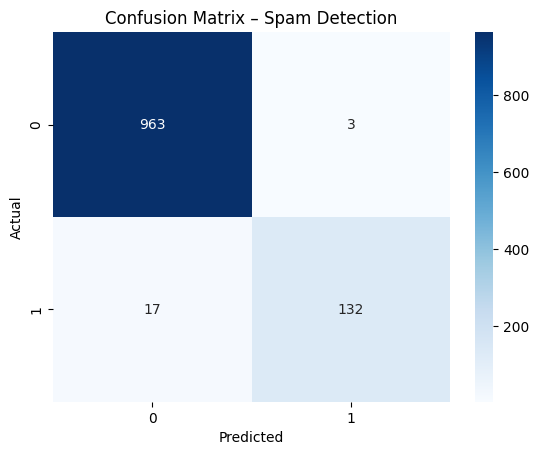

In [55]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix – Spam Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()